# 폐렴아 기다려라 - 폐렴 진단

### ✒️ 개요
의료 인공지능
- 의료 영상의 종류
    - X-ray
    - CT
    - MRI(자기 공명 영상)
- 의료 인공지능을 통해 인간이 미치지 못하는 영역까지도 인공지능이 진단해 줄 수 있다.
- 보다 개개인에게 정확한 진단이 가능해진다.

### ✒️ 목적

- X-ray 이미지를 기반으로 하는 폐렴 딥러닝 모델 제작
    - X-ray에 대한 이해
        - 종류
            - sagittal Plane : 사람 왼쪽과 오른쪽을 나누는 면
            - Frontal plane : 인체를 앞뒤로 나누는 면 **(사용할 데이터)**
            - Transverse plane : 인체를 상하로 나누는 면
        - 흉부 이미지
            - 공기 : 검은 색
            - 갈비뼈 : 하얀색
            - 폐 : 검은색
            - 어깨쪽의 지방 및 근육 : 연한 회색
            
- 왜 폐렴 진단이 중요한가?
     ```
     폐렴(pneumonia 뉴모니아)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다. 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다.```

### ✒️ 과정
- 데이터 이미지
    - 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1-5세 소아 환자 흉부
    - Chest X-Ray Image
        - train
        - test
        - val
    - 확장자 
        - .jpeg
    - 크기
        - 1.2GB
- 이미지 데이터 시각화 및 전처리
- 데이터 증강
- 모델 설계
- 훈련 및 테스트
- 결과 모델 실험
- 회고


In [44]:
# 패키지
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

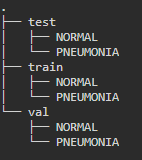

In [45]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 하이퍼 파라미터
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [197]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 가져온다
- train과 val에 있는 데이터를 모은 다음에 train : val을 80:20으로 분할

In [198]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(42)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [199]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person622_virus_1196.jpeg


In [200]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


- train data set이 매우 불균형하다는 것을 알 수 있다.
- test, validation에 경우에는 평가를 위한 Dataset이기 때문에 imbalance한 데이터 셋도 문제가 없다

In [208]:
# tf.data는 tensorflow에서 학습시킬 때 mini batch 작업이 가능하게 해준다
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### training , validataion data

In [209]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [210]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [211]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [212]:
# train, validation data
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [54]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [57]:
# tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
#
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # 고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 균일 하게 요소 선택
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # epoch에 맞춰서 여러번 데이터 셋을 사용할 수 있도록 함
    ds = ds.repeat()
    # batch size만큼의 배치로 주어진다
    ds = ds.batch(BATCH_SIZE)
    # GPU에서 학습하는 동안 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄인다
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

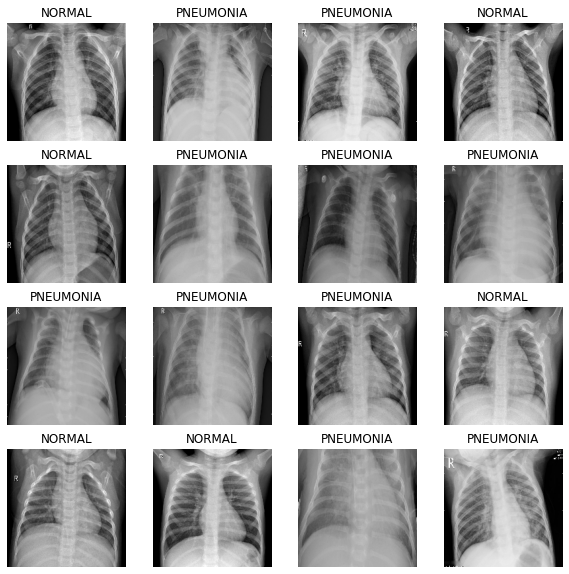

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

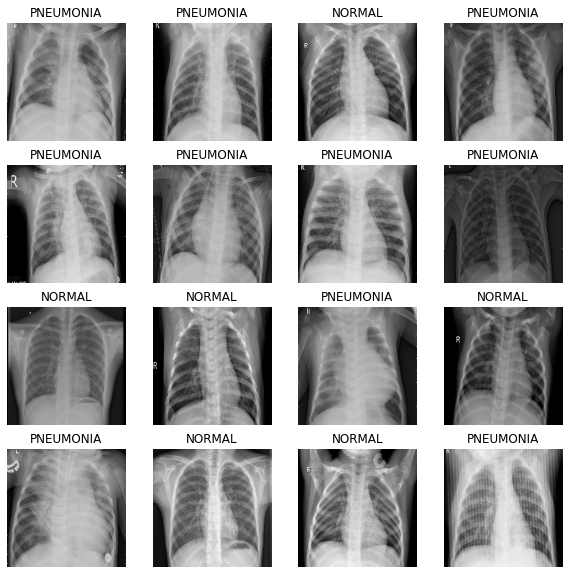

In [16]:
# test
image_batch, label_batch = next(iter(test_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링

In [17]:
# convolution layer
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
# dense layer
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
# 모델 설계
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        # Fc
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Data imbalance 처리
- imbalance한 데이터는 성능이 떨어질 수 있기 때문에 weight balancing이라는 테크닉을 사용한다. 특정 클래스의 데이터에 더 큰 loss를 갖도록 가중치를 부여하는 방법이다.
- fit의 하이퍼파라미터로 전달하면 된다.

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    # 모델 객체 생성
    model = build_model()
    
    
    # 평가 accuracy, precision , recall
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    # opt adam , 손실함수 binary corossenctropy
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

### Model 훈련 및 검증

In [24]:
# mini - batch 단위로 train
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 143s 382ms/step - loss: 0.4001 - accuracy: 0.7981 - precision: 0.9576 - recall: 0.7625 - val_loss: 0.5966 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 100s 384ms/step - loss: 0.2390 - accuracy: 0.9076 - precision: 0.9726 - recall: 0.9013 - val_loss: 1.0688 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 100s 384ms/step - loss: 0.2047 - accuracy: 0.9179 - precision: 0.9762 - recall: 0.9117 - val_loss: 0.1190 - val_accuracy: 0.9683 - val_precision: 0.9932 - val_recall: 0.9633
Epoch 4/10
261/261 [==============================] - 102s 391ms/step - loss: 0.1798 - accuracy: 0.9339 - precision: 0.9800 - recall: 0.9301 - val_loss: 0.5910 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.7277
Epoch 5/10
261/261 [==============================] - 107s 411ms/step - loss: 0.1591 - a

### 훈련 결과 시각화

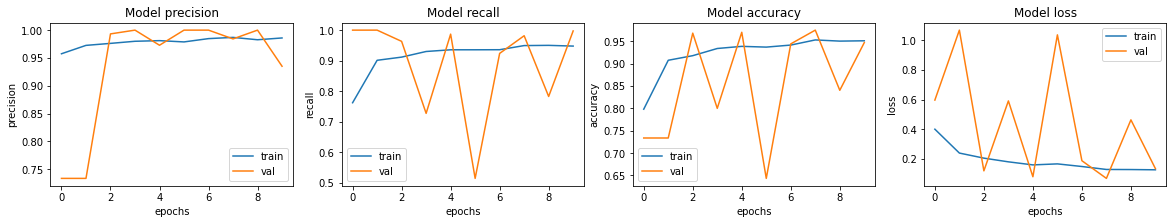

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
# test data 
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.0370 - accuracy: 0.6715 - precision: 0.6560 - recall: 0.9974
Loss: 1.0370116233825684,
Accuracy: 0.6714743375778198,
Precision: 0.655986487865448,
Recall: 0.9974358677864075


### 폐렴 진단기 성능 개선 - ResNet18

In [22]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [124]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [125]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1080
Pneumonia images count in training set: 3105


### Data Augmentation

In [217]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### ResNet18 설계

In [108]:
class LayerBlock(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(LayerBlock, self).__init__(name='')
    
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.act = tf.keras.layers.Activation('relu')
        # residual add layer
        self.add = tf.keras.layers.Add()
        
        # 형상 맞춰주는 용도
        self.conv_shortcut = tf.keras.layers.Conv2D(filters, (1, 1), padding='same')  # Added 1x1 convolution

    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.bn1(x)
        x = self.act(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)

        shortcut = self.conv_shortcut(input_tensor)
        
        # input data 와 layer를 거쳐온 data add
        x = self.add([x, shortcut])
        x = self.act(x)

        return x


In [234]:
class ResNet18(tf.keras.Model):
    def __init__(self, classes, input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)):
        super(ResNet18, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same', input_shape=input_shape)
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        self.conv_1a = LayerBlock(64, 3)
        self.conv_1b = LayerBlock(64, 3)

        self.conv_2a = LayerBlock(128, 3)
        self.conv_2b = LayerBlock(128, 3)

        self.conv_3a = LayerBlock(256, 3)
        self.conv_3b = LayerBlock(256, 3)

        self.conv_4a = LayerBlock(512, 3)
        self.conv_4b = LayerBlock(512, 3)
        
        # dense layer 바로 전에 pooling average pooling
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(classes, activation='softmax')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        x = self.conv_1a(x)
        x = self.conv_1b(x)

        x = self.conv_2a(x)
        x = self.conv_2b(x)

        x = self.conv_3a(x)
        x = self.conv_3b(x)

        x = self.conv_4a(x)
        x = self.conv_4b(x)
        
        # average pooling
        x = self.global_pool(x)

        return self.dense(x)

# 모델 객체 생성    
model = ResNet18(1)
model.build((None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.summary()


Model: "res_net18_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_661 (Conv2D)          multiple                  9472      
_________________________________________________________________
batch_normalization_586 (Bat multiple                  256       
_________________________________________________________________
activation_307 (Activation)  multiple                  0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling multiple                  0         
_________________________________________________________________
layer_block_272 (LayerBlock) multiple                  78528     
_________________________________________________________________
layer_block_273 (LayerBlock) multiple                  78528     
_________________________________________________________________
layer_block_274 (LayerBlock) multiple                 

In [113]:
# 모델 훈련
with tf.device('/GPU:0'):
    model = ResNet18(1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [114]:
# 데이터 imabalance 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [115]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 223s 640ms/step - loss: 0.3544 - accuracy: 0.7421 - precision: 0.7421 - recall: 1.0000 - val_loss: 0.5555 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 168s 645ms/step - loss: 0.2784 - accuracy: 0.7411 - precision: 0.7411 - recall: 1.0000 - val_loss: 2.2963 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 168s 643ms/step - loss: 0.2278 - accuracy: 0.7421 - precision: 0.7421 - recall: 1.0000 - val_loss: 7.1749 - val_accuracy: 0.7413 - val_precision: 0.7413 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 167s 642ms/step - loss: 0.2077 - accuracy: 0.7419 - precision: 0.7419 - recall: 1.0000 - val_loss: 1.6356 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 167s 639ms/step - loss: 0.2119 - a

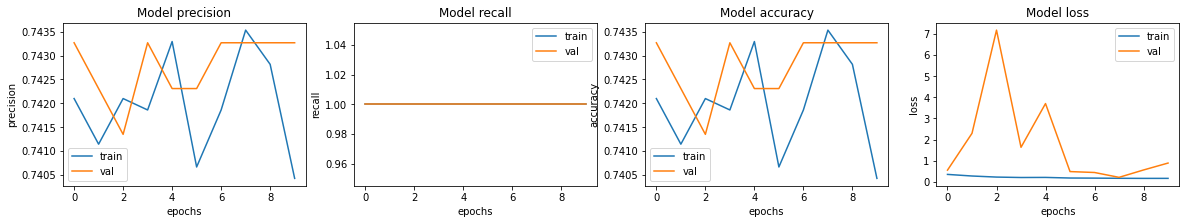

In [122]:
# 결과 확인과 시각화
# history
fig = plt.subplots(2, 2, figsize=(10, 8))

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    plt.subplot(2,2,i+1)
    plt.plot(history.history[met])
    plt.plot(history.history['val_' + met])
    plt.title('Model {}'.format(met))
    plt.xlabel('epochs')
    plt.ylabel(met)
    plt.legend(['train', 'val'])

### Data Augmentation을 다양하게 적용한 경우

In [298]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [299]:
def augment(image, label):
    # 상하 좌우 반전
    image = tf.image.random_flip_left_right(image)  
    image = tf.image.random_flip_up_down(image)
    # 이미지 전치
    image = tf.image.transpose(image)
    
    # 이미지 standardization
    image = tf.image.per_image_standardization(image)
    # 대비 조정
    image = tf.image.adjust_contrast(image, contrast_factor=2.0)  
    
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [310]:
class ResNet18(tf.keras.Model):
    def __init__(self, classes, input_shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)):
        super(ResNet18, self).__init__()
        
        self.data_aug = data_aug
        self.conv = tf.keras.layers.Conv2D(64, 7, padding='same', input_shape=input_shape)
        self.bn = tf.keras.layers.BatchNormalization()
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3, 3))

        self.conv_1a = LayerBlock(64, 3)
        self.conv_1b = LayerBlock(64, 3)

        self.conv_2a = LayerBlock(128, 3)
        self.conv_2b = LayerBlock(128, 3)

        self.conv_3a = LayerBlock(256, 3)
        self.conv_3b = LayerBlock(256, 3)

        self.conv_4a = LayerBlock(512, 3)
        self.conv_4b = LayerBlock(512, 3)

        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.dense = tf.keras.layers.Dense(classes, activation='softmax')
        
        
    # dropout layer 추가
    def call(self, inputs,training=True, mask=None):
        x = self.data_aug(inputs, training=training)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.max_pool(x)

        x = self.conv_1a(x)
        x = self.conv_1b(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        x = self.conv_2a(x)
        x = self.conv_2b(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        x = self.conv_3a(x)
        x = self.conv_3b(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        x = self.conv_4a(x)
        x = self.conv_4b(x)
        x = tf.keras.layers.Dropout(0.3)(x)

        x = self.global_pool(x)

        return self.dense(x)

model = ResNet18(1)
model.build((None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.summary()


Model: "res_net18_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_1387 (Conv2D)         multiple                  9472      
_________________________________________________________________
batch_normalization_1079 (Ba multiple                  256       
_________________________________________________________________
activation_568 (Activation)  multiple                  0         
_________________________________________________________________
max_pooling2d_69 (MaxPooling multiple                  0         
_________________________________________________________________
layer_block_504 (LayerBlock) multiple                  78528     
_________________________________________________________________
layer_block_505 (LayerBlock) multiple                 

In [321]:
# optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

In [328]:
# 모델 훈련
with tf.device('/GPU:0'):
    model = ResNet18(1)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [329]:
# 데이터 imabalance 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [330]:
# 하이퍼파라미터
BATCH_SIZE = 16
EPOCHS = 10

In [331]:
with tf.device('/GPU:0'):
    history1 = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        #class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 352s 1s/step - loss: 23.3285 - accuracy: 0.7422 - precision: 0.7422 - recall: 1.0000 - val_loss: 0.6078 - val_accuracy: 0.7418 - val_precision: 0.7418 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 339s 1s/step - loss: 0.4476 - accuracy: 0.7422 - precision: 0.7422 - recall: 1.0000 - val_loss: 0.6194 - val_accuracy: 0.7437 - val_precision: 0.7437 - val_recall: 1.0000
Epoch 3/10
216/261 [=======================>......] - ETA: 52s - loss: 0.3961 - accuracy: 0.7399 - precision: 0.7399 - recall: 1.0000

KeyboardInterrupt: 

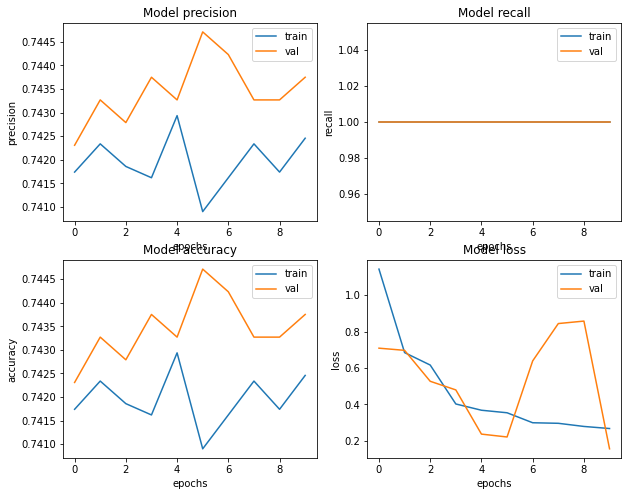

In [327]:
# 결과 확인과 시각화
# history
fig = plt.subplots(2, 2, figsize=(10, 8))

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    plt.subplot(2,2,i+1)
    plt.plot(history1.history[met])
    plt.plot(history1.history['val_' + met])
    plt.title('Model {}'.format(met))
    plt.xlabel('epochs')
    plt.ylabel(met)
    plt.legend(['train', 'val'])

- 조건
    - batch size 32
    - data augumentation x
    - optimizer Adam learning rate 0.001
    - dropout x
    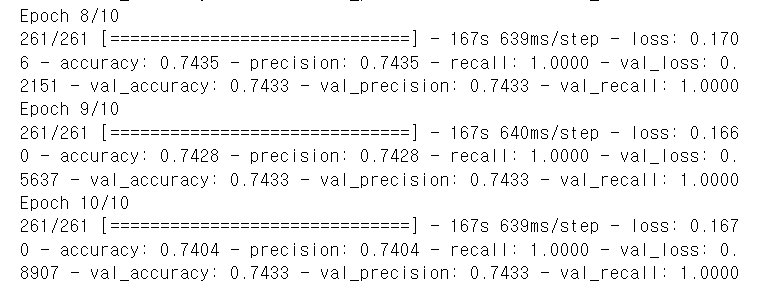
    ---
    - batch size 32
    - data augumentation o
    - optimizer Adam learning rate 0.001
    - dropout 비율 x
    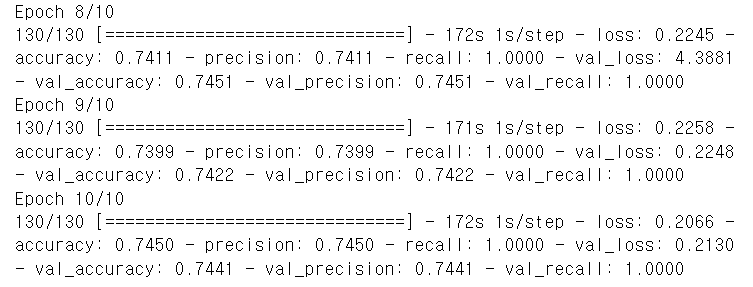
    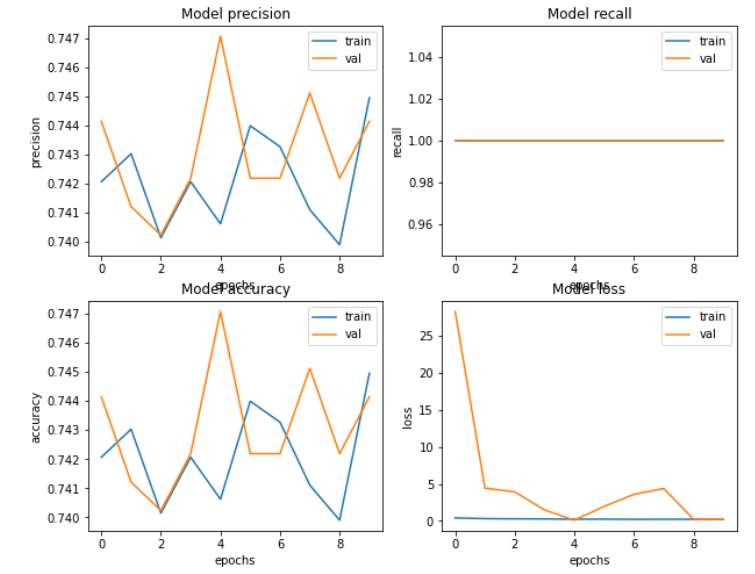
    ---
    - batch size 16
    - data augumentation o
    - optimizer Adam learning rate 0.01
    - dropout 비율 0.3
    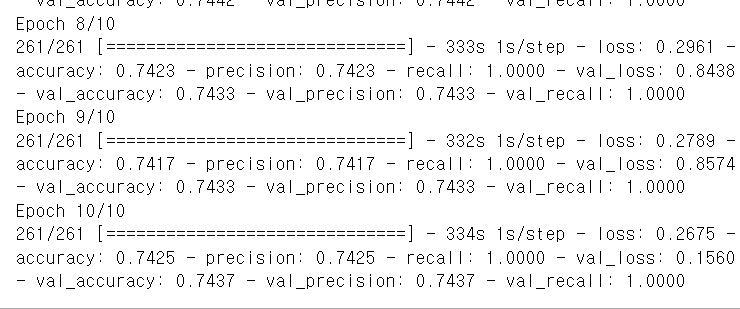
    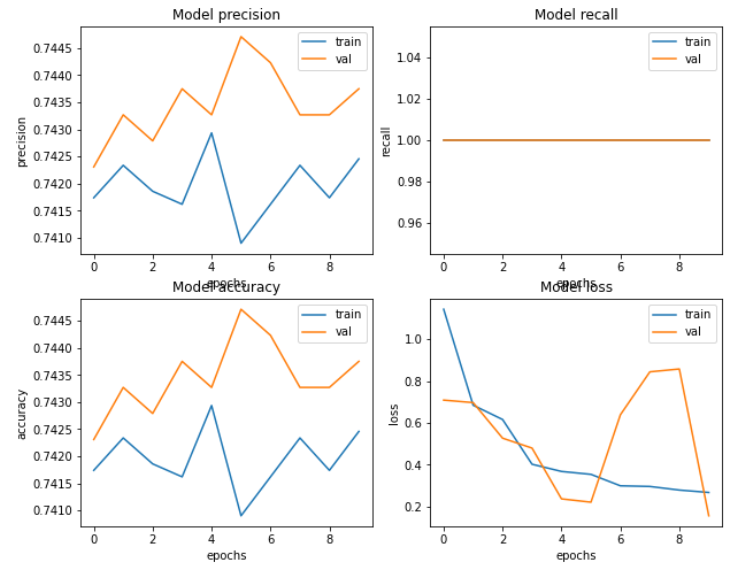
    ---
    - batch size 16
    - data augumentation o
    - optimizer Adam learning rate 0.01
    - dropout 비율 0.3
    - Weight 처리하지 않은 경우
    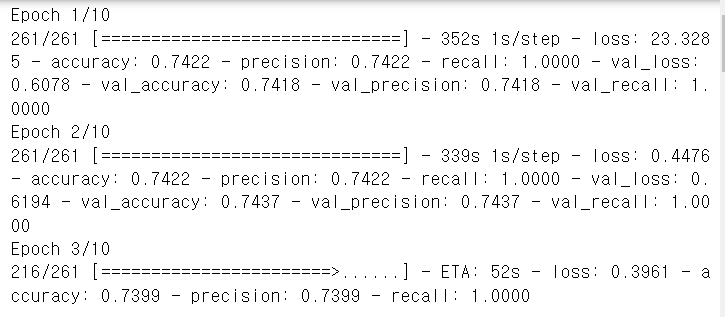
    

### 회고
- 이전에는 이미지 scale이 맞지 않을 경우에는 이미지를 다른 곳에서 구하거나, 적은 데이터 수에 맞게 삭제하는 방식으로 진행했었다. 그런데 weight를 가지고 처리하는 경우는 처음 알게 되어서 좋았던 것 같다.
- weight를 처리해줄 때와 해주지 않을 때를 비교해보는 과정에서 확실히 scale에 대한 중요성을 알 수 있었다.
- data augumentation은 좌우 반전외에도 표준화와 대비 조정등을 해주었다. 그외에는 같은 조건에서 돌렸던 모델에서 비교해본 결과 10%의 정확도 향상이 있었다. 지금은 epochs를 적게 가져갔지만 많이 돌려볼 경우에는 사실 augmentation도 노이즈의 일부가 될 수 있기 때문에 고려해볼 요소인 것 같다.
- 이후에 batch는 이전에도 실험할 때도 항상 성능에 많은 영향을 주는 하이퍼파라미터라고 느꼈기 때문에 batch도 조금씩 조절해보았다.  데이터가 많이 없기 때문에 크게 주는 것은 무리였고, 적당히 16,32 로 돌려보았다.epoch를 많이 가져갈 것도 아니었기 때문에 learning rate도 0.01로 더 크게 해서 돌렸다. dropout도 30% 정도 함께 구성했다. 그 결과 validataion loss가 훨씬 안정적으로 수렴했다.

- 참고자료

    -  https://www.researchgate.net/figure/ResNet-with-18-layers-depicted-in-five-blocks_fig4_333787753
    - https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/
    - https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50
    - https://mypark.tistory.com/entry/Tensorflow-2Keras-Week-4-Implementing-ResNet
    - https://github.com/keras-team/keras/blob/v2.14.0/keras/applications/resnet.py
    - https://www.tensorflow.org/api_docs/python/tf/image

- 오류 디버깅
    - GPT 3.5
    - stackoverflow